# Chronos Vignette

This vignette walks through a simple exercise in training Chronos on a subset of DepMap public 20Q4 and the Sanger Institute's Project Score data. 

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import chronos
import os
from matplotlib import pyplot as plt
import seaborn as sns
from taigapy import default_tc as tc

Some tweaks that will make plots more legible

In [3]:
from matplotlib import rcParams
rcParams['axes.titlesize'] = 14
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
rcParams['savefig.dpi'] = 200
rcParams['savefig.transparent'] = False
rcParams['font.family'] = 'Arial'
rcParams['font.size'] = '11'
rcParams['figure.dpi'] = 200
rcParams["savefig.facecolor"] = (1, 1, 1.0, 0.2)

rcParams['xtick.labelsize'] = 10
rcParams['ytick.labelsize'] = 10
rcParams['legend.fontsize'] = 7

## Setting up the Data

Chronos always requires at least three dataframes: 
* a matrix of readcounts with sequenced entities as the index, individual sgRNAs as the columns, and values indicating how many reads were found for that sgRNA. A sequenced entity any vector of sgRNA readcounts read out during the experiment. It could be a sequencing run of pDNA, or of a biological replicate at some time point during the experiment.
* A sequence map mapping sequenced entities to either pDNA or a cell line and giving the days since infection and pDNA batch. 
* A guide map mapping sgRNAs to genes. Each sgRNA included must map to one and only one gene.

Below, we'll load a small subset of the DepMap Avana data. The files have been reformatted from the release to the format Chronos expects

In [4]:
sequence_map = pd.read_csv("Data/SampleData/AvanaSequenceMap.csv")
guide_map = pd.read_csv("Data/SampleData/AvanaGuideMap.csv")
readcounts = chronos.read_hdf5("Data/SampleData/AvanaReadcounts.hdf5")

Sequence maps must have the columns

* sequence_id (str), which must match a row in readcounts
* cell_line_name (str). Must be "pDNA" for pDNA, and each pDNA batch must have at least one pDNA measurement.
* pDNA batch (any simple hashable type, preferably int or str). pDNA measurements sharing the same batch will be grouped and averaged, then used as the reference for all biological replicate sequencings assigned that same batch. If you don't have multiple pDNA batches (by far the most common experimental condition), just fill this column with 0 or some other constant value.
* days: days post infection. This value will be ignored for pDNA.

Other columns will be ignored.

In [5]:
sequence_map[:5]

,sequence_ID,ScreenID,days,pDNA_batch,Replicate,ScreenType,cell_line_name,ModelConditionID,Library,PassesQC
0,HEL-311Cas9_RepA_p4_Avana-3,SC-000004.AV01,21,Avana-3,A,2DS,ACH-000004,MC-000004-pA3k,Avana,True
1,HEL-311Cas9_RepB_p4_Avana-3,SC-000004.AV01,21,Avana-3,B,2DS,ACH-000004,MC-000004-pA3k,Avana,True
2,KU812-311cas9-RepA-p6_Avana-3,SC-000074.AV01,21,Avana-3,A,2DS,ACH-000074,MC-000074-OKtM,Avana,True
3,KU812-311cas9-RepB-p6_Avana-3,SC-000074.AV01,21,Avana-3,B,2DS,ACH-000074,MC-000074-OKtM,Avana,True
4,T47D-311Cas9-RepA-p6_Avana-4,SC-000147.AV01,21,Avana-4,A,2DS,ACH-000147,MC-000147-Uovr,Avana,True


Guide maps must have the columns 

* sgrna (str): must match a column in readcounts. An sgrna can only appear once in this data frame.
* gene (str): the gene the sgrna maps to.

Other columns will be ignored.

In [6]:
guide_map[:4]

,sgrna,GenomeAlignment,gene,nAlignments,DropReason,UsedByChronos
0,AAAAATGCGCAAATTCAGCG,chr3_138742712_-,PIK3CB (5291),1.0,NaN,True
1,AAAACACATCAGTATAACAT,chr3_49368469_+,RHOA (387),1.0,NaN,True
2,AAAACTACAGAAGCCTCCCG,chr10_34450424_-,PARD3 (56288),1.0,NaN,True
3,AAAAGGCCTGACATATCTGA,chr15_66444677_+,MAP2K1 (5604),2.0,NaN,True


Finally, here's what readcounts should look like. They can include NaNs. Note the axes.

In [7]:
readcounts.iloc[:4, :3]

,AAAAATGCGCAAATTCAGCG,AAAACACATCAGTATAACAT,AAAACTACAGAAGCCTCCCG
HEL-311Cas9_RepA_p4_Avana-3,101.0,224.0,636.0
HEL-311Cas9_RepB_p4_Avana-3,147.0,400.0,350.0
KU812-311cas9-RepA-p6_Avana-3,124.0,191.0,364.0
KU812-311cas9-RepB-p6_Avana-3,129.0,536.0,1280.0


To QC the data, we'll want control groups. We'll use predefined sets of common and nonessential genes, and use these to define control sets of sgRNAs.

In [8]:
common_essentials = pd.read_csv("Data/SampleData/AchillesCommonEssentialControls.csv")["Gene"]
nonessentials = pd.read_csv("Data/SampleData/AchillesNonessentialControls.csv")["Gene"]

In [9]:
positive_controls = guide_map.sgrna[guide_map.gene.isin(common_essentials)]
negative_controls = guide_map.sgrna[guide_map.gene.isin(nonessentials)]

### Normalizing Readcounts

It's recommended that you normalize the readcounts before running `nan_outgrowths` below to correct for library size/sequencing depth effects. Chronos' `normalize_readcounts` function has different behavior depending on what is provided. In the ideal case that both a `sequence_map` and abundant negative controls (>=1000) are supplied, normalization process in two stages:
- pDNA counts are scaled so that the modes of the readcount log distributions are aligned.
- Each other sequence is then scaled such that the median of the log reads of negative controls within the sequence matches the median of the same guides in the negative controls

In [10]:
readcounts = chronos.normalize_readcounts(readcounts, negative_controls, sequence_map)

### NaNing clonal outgrowths

In Achilles, we've observed rare instances where a single guide in a single biological replicate will produce an unexpectedly large number of readcounts, while other guides targeting the same gene or other replicates of the same cell line do not show many readcounts. We suspect this is the result of a single clone gaining some fitness advantage. Although it _could_ be related to a change induced by the guide, in general it's probably misleading. Therefore Chronos has an option to identify and remove these events. Note this change occurs in place.

In [11]:
chronos.nan_outgrowths(readcounts=readcounts, guide_gene_map=guide_map,
                                   sequence_map=sequence_map)

calculating LFC
stacking and annotating LFC
finding group boundaries
removing cases with only one guide and replicate
finding maximal values
making mask
found 218 outgrowths, 6.8E-04 of the total
pivoting mask
aligning_mask
NaNing


/Users/dempster/packages/chronos_public/chronos/model.py:486: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)\


### QCing the data

You can generate a report with basic QC metrics about your data. You don't have to have control guides to do this, but the report is most useful if you do. If you don't have the `reportlab` python package installed, this section will error and should be skipped. This command will write a pdf report named "Initial QC.pdf" in the `./Data/reports` directory.

In [12]:
reportdir = "./Data/reports"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/reports"
! mkdir "./Data/reports"

In [13]:
from chronos import reports
metrics = reports.qc_initial_data(
    "Initial QC", readcounts, sequence_map,guide_map, 
    negative_controls, positive_controls, directory=reportdir, 
       )

calculating replicate correlation
generating control separation metrics
Plotting log fold-change distribution


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


plotting control separation metrics


Look in the Data/reports directory to see the QC report, "Initial QC.pdf".

## Train Chronos

### Creating the model

Now we initialize the model. Note the form of the data: each of the three parameters is actually a dictionary. If we were training the model with data from multiple libraries simultaneously, each library's data would have its own entries in the dict. 

The `negative_control_sgrnas` is an optional parameter, but including it will allow 1. better removal of library size effects from readcounts, and 2. estimation of the negative binomial quadratic overdispersion parameter per screen, which is otherwise a fixed hyperparameter. If provided, these should be cutting sgRNAs that are strongly expected to have no viability impact.

`log_dir` is an optional argument containing a directory for tensorflow to write summaries to. We include it here so that tensorboard can load the model.

In [14]:
logdir = "./Data/logs"
# permanently deletes the directory - careful if you edit this line!
! rm -rf "./Data/logs"
! mkdir "./Data/logs"

In [15]:
import warnings
warnings.filterwarnings("default")

In [16]:
model = chronos.Chronos(
    sequence_map={"avana": sequence_map},
    guide_gene_map={"avana": guide_map},
    readcounts={"avana": readcounts},
    negative_control_sgrnas={"avana": negative_controls},
    log_dir=logdir
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 92 unique late time points and 44 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [92, 1] for avana

building late observed timepoints
	built normalized timepoints for avana with shape (92, 3474) (replicates X g

2025-05-12 14:43:09.917096: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-05-12 14:43:09.967808: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance/avana/Assign' id:7 op device:{requested: '', assigned: ''} def:{{{node excess_variance/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance/avana, excess_variance/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building variables

building t0 reads estimate
made t0 batch with shape (3, 3474) for avana
building guide efficacy
built guide efficacy: shape [1, 3475]
building growth rate
built growth rate: shape {'avana': [92, 1]}

building replicate efficacy
built replicate efficacy: shapes {'avana': [92, 1]}
building screen delay
built screen delay
building gene effect
built core gene effect: 44 cell lines by 883 genes


Connecting graph nodes in model

building effective days
built effective days, shapes {'avana': [92, 883]}

building gene effect growth graph nodes
built gene effect growth graph nodes, shapes {'avana': [92, 883]}

building combined efficacy
built combined efficacy, shape {'avana': [92, 3474]}
built expanded combined efficacy, shapes {'avana': [92, 3474]}

building growth estimates of edited cells and overall estimates of fold change in guide abundance
built growth and change

building unnormalized estimates of final abundance
built unnormalized abundance

building normalized 

2025-05-12 14:43:10.593833: W tensorflow/c/c_api.cc:305] Operation '{name:'GE/library_effect/avana/Assign' id:121 op device:{requested: '', assigned: ''} def:{{{node GE/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE/library_effect/avana, GE/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
	avana _cost
	avana _full_costs
ready to train


If you have tensorboard, the cell below will show Chronos' node structure. `GE` means gene effect (relative change in growth rate), `FC` means predicted fold change, `t0` is the inferred relative guide abundance at t0, and `out_norm` is the predicted readcounts. 

In [17]:
%reload_ext tensorboard
!kill $(ps -e | grep 'tensorboard' | awk '{print $1}')
%tensorboard --logdir ./data/logs

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=42447) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

Now, optimizing the model:

### Train

Below, we train  the model for 301 epochs. This should take a minute or so with periodic updates provided

In [18]:
model.train(301)

NB2 cost 0.33721554484347116
Full cost 0.4228461554134784
relative_growth_rate
	avana max 1.050, min 0.96142
mean guide efficacy 0.9992278306583418
t0_offset SD: [('avana', 7.069257140491685e-05)]

gene mean -0.21225130376274984
SD of gene means 0.29868440881136593
Mean of gene SDs 0.257435304179317



51 epochs trained, time taken 0:00:02, projected remaining 0:00:10
NB2 cost 0.22403717046363864
Full cost 0.26404061048386435
relative_growth_rate
	avana max 1.545, min 0.57172
mean guide efficacy 0.9399924267562648
t0_offset SD: [('avana', 0.14393955972706285)]

gene mean -0.03467248674308783
SD of gene means 0.43872183131967385
Mean of gene SDs 0.2220858933292567



101 epochs trained, time taken 0:00:04, projected remaining 0:00:08
NB2 cost 0.2120744212814224
Full cost 0.23769834199087037
relative_growth_rate
	avana max 1.617, min 0.49836
mean guide efficacy 0.8834128523218803
t0_offset SD: [('avana', 0.13781116441509433)]

gene mean 0.00020487617228035474
SD of gene means 0.446861106

## After Training

### Saving and Restoring

Chronos' `save` method dumps all the inputs, outputs, and model parameters to the specified directory. These files are written such that they can be read in individually and analyzed, but also used to restore the model by passing the directory path to the function `load_saved_model`.

In [19]:
savedir = "Data/Achilles_run"

In [20]:
if not os.path.isdir(savedir):
    os.mkdir(savedir)

In [21]:
model.save(savedir, overwrite=True)

In [22]:
print("Saved files:\n\n" + '\n'.join(['\t' + s for s in os.listdir(savedir)
                if s.endswith("csv")
                or s.endswith("hdf5")
                or s.endswith("json")
                ]))

Saved files:

	library_effect.csv
	cell_line_growth_rate.csv
	avana_predicted_readcounts.hdf5
	growth_rate.csv
	parameters.json
	guide_efficacy.csv
	avana_sequence_map.csv
	replicate_efficacy.csv
	t0_offset.csv
	avana_predicted_lfc.hdf5
	avana_guide_gene_map.csv
	gene_effect_corrected.hdf5
	avana_negative_control_sgrnas.csv
	screen_delay.csv
	screen_excess_variance.csv
	cell_line_efficacy.csv
	gene_effect.hdf5
	avana_readcounts.hdf5


The .hdf5 files are binaries written with chronos' `write_hdf5` function, which is an efficient method for writing large matrices. They can be read with chronos' `read_hdf5` function.

Restoring the model can be done with a single function call:

In [23]:
model_restored = chronos.load_saved_model(savedir)



Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 3474 unique guides and 883 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 92 unique late time points and 44 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [92, 1] for avana

building late observed timepoints
	built normalized timepoints for avana with shape (92, 3474) (replicates X guides)

building t0 rea

2025-05-12 14:43:24.155093: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_1/avana/Assign' id:3006 op device:{requested: '', assigned: ''} def:{{{node excess_variance_1/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_1/avana, excess_variance_1/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Creating optimizer
initializing rest of graph
	verifying graph integrity
verifying user inputs


2025-05-12 14:43:24.654139: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_1/library_effect/avana/Assign' id:3120 op device:{requested: '', assigned: ''} def:{{{node GE_1/library_effect/avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_1/library_effect/avana, GE_1/library_effect/avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
	avana _cost
	avana _full_costs
ready to train
assigning trained parameters
	library effect
	gene effect
	guide efficacy
	cell efficacy
	growth rate
	screen excess variance
	screen delay
	t0 offset
Complete.
Cost when saved: 0.211930, cost now: 0.211930
Full cost when saved: 0.236201, full cost now: 0.236204


In [24]:
print("trained model cost: %f\nrestored model cost: %f" % (model.cost, model_restored.cost))

trained model cost: 0.211930
restored model cost: 0.211930


2025-05-12 14:43:25.825033: W tensorflow/c/c_api.cc:305] Operation '{name:'GE/library_effect/avana/Adam_1/Assign' id:1514 op device:{requested: '', assigned: ''} def:{{{node GE/library_effect/avana/Adam_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE/library_effect/avana/Adam_1, GE/library_effect/avana/Adam_1/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


The most important file for most use cases is gene_effect.hdf5, which holds Chronos' estimate of the relative change in growth rate caused by gene knockouts. Negative values indicate inhibitory effects. You can also access the gene effect (and other parameters) from the trained model directly:

In [25]:
gene_effects = model.gene_effect

gene_effects.iloc[:4, :5]

gene,A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947)
cell_line_name,,,,,
ACH-000004,0.316260,0.068512,0.278499,0.428854,0.191421
ACH-000074,0.369366,0.473016,0.654711,0.386836,0.314882
ACH-000147,0.352329,0.314244,0.451148,0.124877,0.421220
ACH-000168,0.332543,0.384565,0.535501,0.306003,0.277280


If your library includes many depleting genes with negative gene effect scores, this can drive nonessential genes towards positive values as Chronos tries to maintain the overall mean score near 0: 

In [26]:
print("Mean of all effects: %1.3f, mean of nonessential gene effects: %1.3f" %(
    np.nanmean(gene_effects.mean()), np.nanmean(gene_effects.reindex(columns=nonessentials))
))

Mean of all effects: -0.001, mean of nonessential gene effects: 0.308


We usually want nonessential gene effects to be centered at 0, so we can interpret 0 gene effect as "no impact on viability." This is a trivial change to make.

In [27]:
gene_effects -= np.nanmean(gene_effects.reindex(columns=nonessentials))

Text(0.5, 0, 'Distribution of adjusted gene effects')

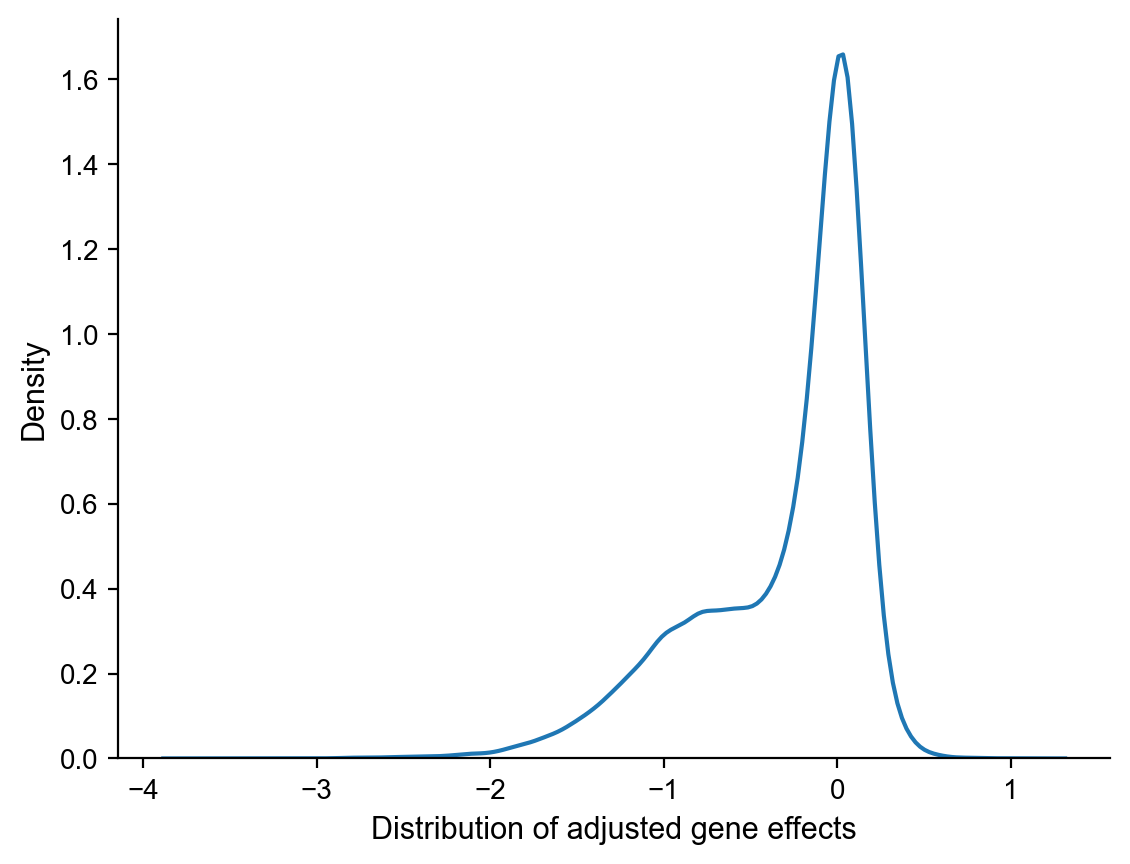

In [28]:
sns.kdeplot(np.ravel(gene_effects))
plt.xlabel("Distribution of adjusted gene effects")

### Copy Number Correction

If you have gene-level copy number calls, Chronos includes an option to correct gene effect scores after the fact. This works best if the data has been scaled, as above.

In [29]:
cn = chronos.read_hdf5("Data/SampleData/OmicsCNGene.hdf5")
cn.iloc[:4, :3]

,A1CF (29974),A2M (2),A2ML1 (144568)
ACH-001636,1.110663,1.047670,1.047670
ACH-000784,1.193826,1.161938,1.109943
ACH-000147,1.365585,0.499068,0.499068
ACH-000657,1.033547,1.040547,1.040547


Unfortunately, we don't have copy number calls for one of the genes targeted by the Avana library:

In [30]:
try:
    corrected, shifts = chronos.alternate_CN(gene_effects, cn)
except ValueError as e:
    print(e)

Missing 1 genes from gene_effect in copy_number.
Examples: ['POU2AF3 (120376)']


We could choose to drop these genes. Instead, we'll assume normal ploidy (=1, in the current CCLE convention) for them and fill in the CN matrix accordingly.

In [31]:
for col in set(gene_effects.columns) - set(cn.columns):
    cn[col] = 1

In [32]:
corrected, shifts = chronos.alternate_CN(gene_effects, cn)


Fitting cell line group 1 of 1
finding low CN gene effect shifts
smoothing and interpolating cutting toxicity for all genes
constructed spline matrix of shape 38852, 105
	cost: 0.04173646899586486
	cost: 0.040778058226723
	cost: 0.04063122928988413
	cost: 0.04054049379409296
	cost: 0.040476957181968906
	cost: 0.04043106153844772
generating matrix


The `shifts` dataframe contains some information about the inferred CN effect, while `corrected` contains the corrected gene effects matrix. Overall, gene effect matrices will change little after correction, since most genes in most lines are near diploid.

We'll write the corrected dataframe to the saved directory we made earlier

In [33]:
chronos.write_hdf5(corrected, os.path.join(savedir, "gene_effect_corrected.hdf5"))

### QC report

The function `dataset_qc_report` in the `reports` module of Chronos presents a variety of QC metrics and interrogates some specific examples. The report minimally requires a set of positive and negative control genes. To get the full report requires copy number, mutation data, expression data, a list of expression addictions (genes which are dependencies in highly expressing lines), and oncogenic mutations.

Below, we'll load an annotated DepMap MAF file (subsetted to our cell lines). We'll select gain of function cancer driver events from it and generate a binary mutation matrix. We have a prior belief that cell lines with driver gain of function mutation events will be dependent on the mutated gene, so this matrix will be used by the QC report to assess our ability to identify selective dependencies. Specifically, we expect the oncogenes in this matrix to be dependencies in cell lines where the matrix is `True`, and not otherwise.

In [34]:
maf = pd.read_csv("Data/SampleData/OmicsSomaticMutations.csv")

In [35]:
cancer_relevant = maf[
  (
      maf.Driver | maf.LikelyDriver  
  ) & (
      maf.LikelyGoF
  )
]


cancer_relevant = cancer_relevant[~cancer_relevant.duplicated(subset=["ModelID", "Gene"])]

cancer_relevant['truecol'] = True

gof_matrix_base = pd.pivot(cancer_relevant, index="ModelID", columns="Gene", values="truecol")

Another way to evaluate selective dependencies is using expression addictions, a common pattern in which a gene is a stronger dependency in lines with higher expression. We'll use a list derived from DepMap RNAi (Tsherniak et al., Cell 2017), and subset our expression matrix to match.

In [36]:
expression_addictions = pd.read_csv("Data/SampleData/RNAiExpressionAddictions.csv")['Gene']

In [37]:
addiction_expressions = chronos.read_hdf5("Data/SampleData/OmicsExpressionProteinCodingGenesTPMLogp1.hdf5")[
    expression_addictions
]

Now, we're ready to run the QC report on Chronos' results:

In [38]:
metrics = reports.dataset_qc_report("ChronosAvana", savedir, 
                          common_essentials, nonessentials,
                          gof_matrix_base, addiction_expressions,
                          cn, directory="Data/reports",
                          gene_effect_file="gene_effect_corrected.hdf5"
                         )

Loading data from Data/Achilles_run
plotting global control separation
plotting selective dependency separation
plotting gene effect mean relationships
plotting copy number effect
plotting screen efficacy and growth rate
plotting readcount predictions
plotting LFC predictions
plotting difference from naive gene score
summarizing
plotting genes with low agreement with naive gene effect
	NEDD1 (121441)
Guide and replicate key for NEDD1 (121441), ACH-000614:
avana    av
dtype: object
GGCTGACACTCCTCTAACTG    avGuide1
TAGAACTGTGGCAATGGACG    avGuide2
TCTATGTATTTGGTAAGCGG    avGuide3
TGGCTATTGGATCTTCCCGG    avGuide4
dtype: object
RVH421-311Cas9_RepA_p5_Avana-3        avRep1
RVH421-311Cas9_RepB_p5_Avana-3        avRep2
RVH421RPMI-311Cas9-RepA-p6_Avana-4    avRep3
RVH421RPMI-311Cas9-RepB-p6_Avana-4    avRep4
dtype: object
Guide and replicate key for NEDD1 (121441), ACH-000074:
avana    av
dtype: object
GGCTGACACTCCTCTAACTG    avGuide1
TAGAACTGTGGCAATGGACG    avGuide2
TCTATGTATTTGGTAAGCGG    av

## Identifying Hits

You may be interested in getting a list of genes that are true dependencies in your screen. Chronos provides two methods to do this:

- Given a set of negative control genes (or a boolean matrix of individual genes within specific cell lines that are negative controls, such as a matrix of unexpressed genes), Chronos can compute empirical p-values for the null hypothesis that the KO had no viability effect against the alternative hypothesis that it caused loss of viability
-  Given a set of positive and negative control genes, Chronos can estimate the probability that a given gene effect score came from the distribution of positive controls vs negative controls. If the controls are representative of essential/nonessential genes, then the probability tells you how likely it is that a given score represents an essential gene for that cell line. 

To get an unbiased estimate, is important not to use CRISPR results from the same library to choose or refine the control sets. We want the scores for the gene sets to capture any bias or artifacts present in CRISPR.

In [39]:
from chronos.hit_calling import get_probability_dependent, get_pvalue_dependent

**Note**: you should see UserWarnings with the following two cells that some negative/positive controls are missing from gene effect - this is expected. You should only worry about this warning if you expect all the controls to be present in your library.

In [40]:
# Expect a warning!
pvalues = get_pvalue_dependent(corrected, nonessentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:1335: UserWarning: Not all negative_controls found in the gene effect columns: ['KRTAP10-6 (386674)', 'KRTAP4-7 (100132476)', 'OR2T33 (391195)', 'KRTAP9-4 (85280)', 'DEFB104A (140596)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))


In [41]:
# Expect a warning!
probabilities = get_probability_dependent(corrected, nonessentials, common_essentials)

/Users/dempster/packages/chronos_public/chronos/hit_calling.py:1335: UserWarning: Not all positive controls found in the gene effect columns: ['RPL7L1 (285855)', 'WDR70 (55100)', 'RPL23A (6147)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))
/Users/dempster/packages/chronos_public/chronos/hit_calling.py:1335: UserWarning: Not all negative controls found in the gene effect columns: ['KRTAP10-6 (386674)', 'KRTAP4-7 (100132476)', 'OR2T33 (391195)', 'KRTAP9-4 (85280)', 'DEFB104A (140596)']
  warn("Not all %s found in the gene effect columns: %r" % (label, missing[:5]))
100%|██████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 255.11it/s]


Each of these has advantages and disadvantages for hit-calling. The probability of dependency is highly dependent on choosing a set of positive controls that accurately capture the distribution of gene-loss-driven depleting phenotypes in your screen. Too stringent a list will cause underestimates, while too loose a list will lead to failure control false discovery. The inverse is true of the negative controls, but it is often possible to identify a very rigorous and representative set of negative controls using unexpressed genes. You should plot the distributions of all your gene effect scores, your negative controls, and your positive controls to see if the positive controls really do represent the left tail:

Text(0.5, 0, 'Gene Effect')

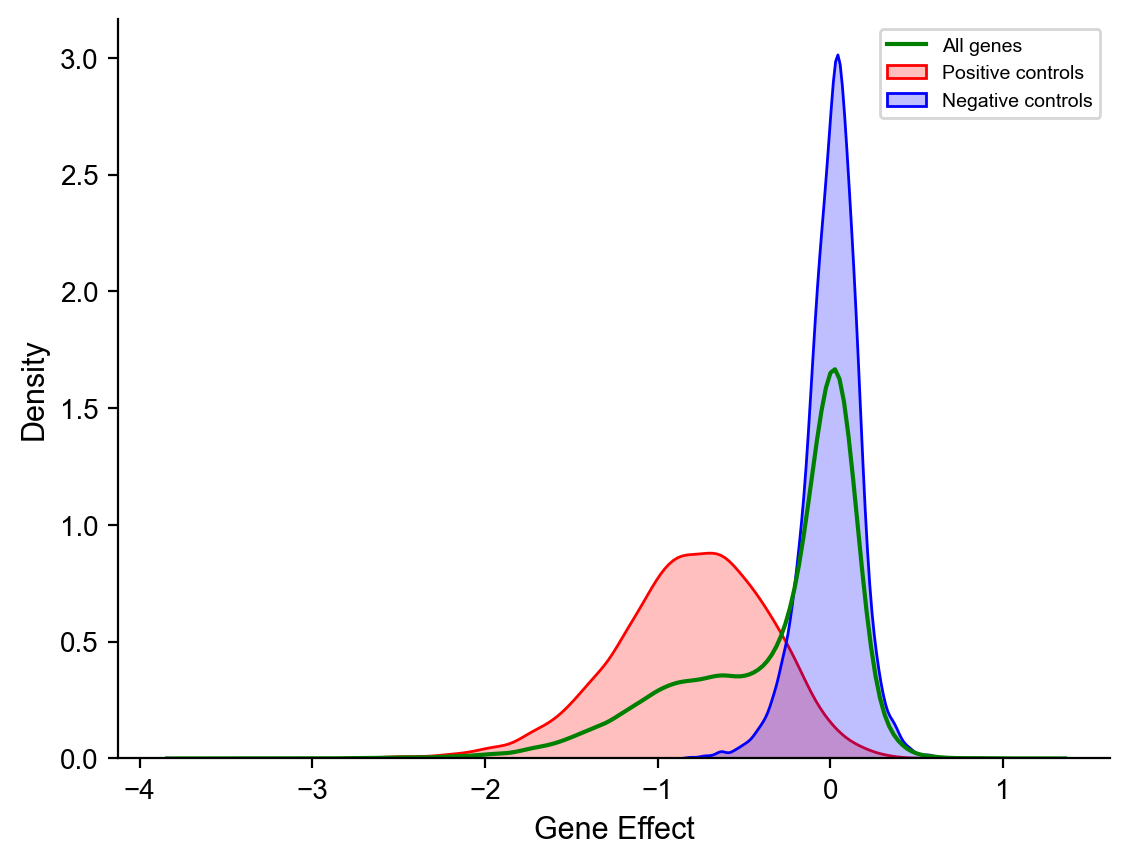

In [42]:
sns.kdeplot(np.ravel(corrected), label="All genes", color="green")
sns.kdeplot(np.ravel(corrected.reindex(columns=common_essentials)), label="Positive controls", color="red", fill=True)
sns.kdeplot(np.ravel(corrected.reindex(columns=nonessentials)), label="Negative controls", color="blue", fill=True)
plt.legend()
plt.xlabel("Gene Effect")

On the other hand, the power of the empirical p-values will be strictly limited by the number of negative controls. In fact, the minimum possible _p_ that can be achieved is 1 / len(negative_controls). This is likely to be an issue in a subgenome library. Below, we see the effect of this cap on significance:

Text(0, 0.5, '-Log10 P')

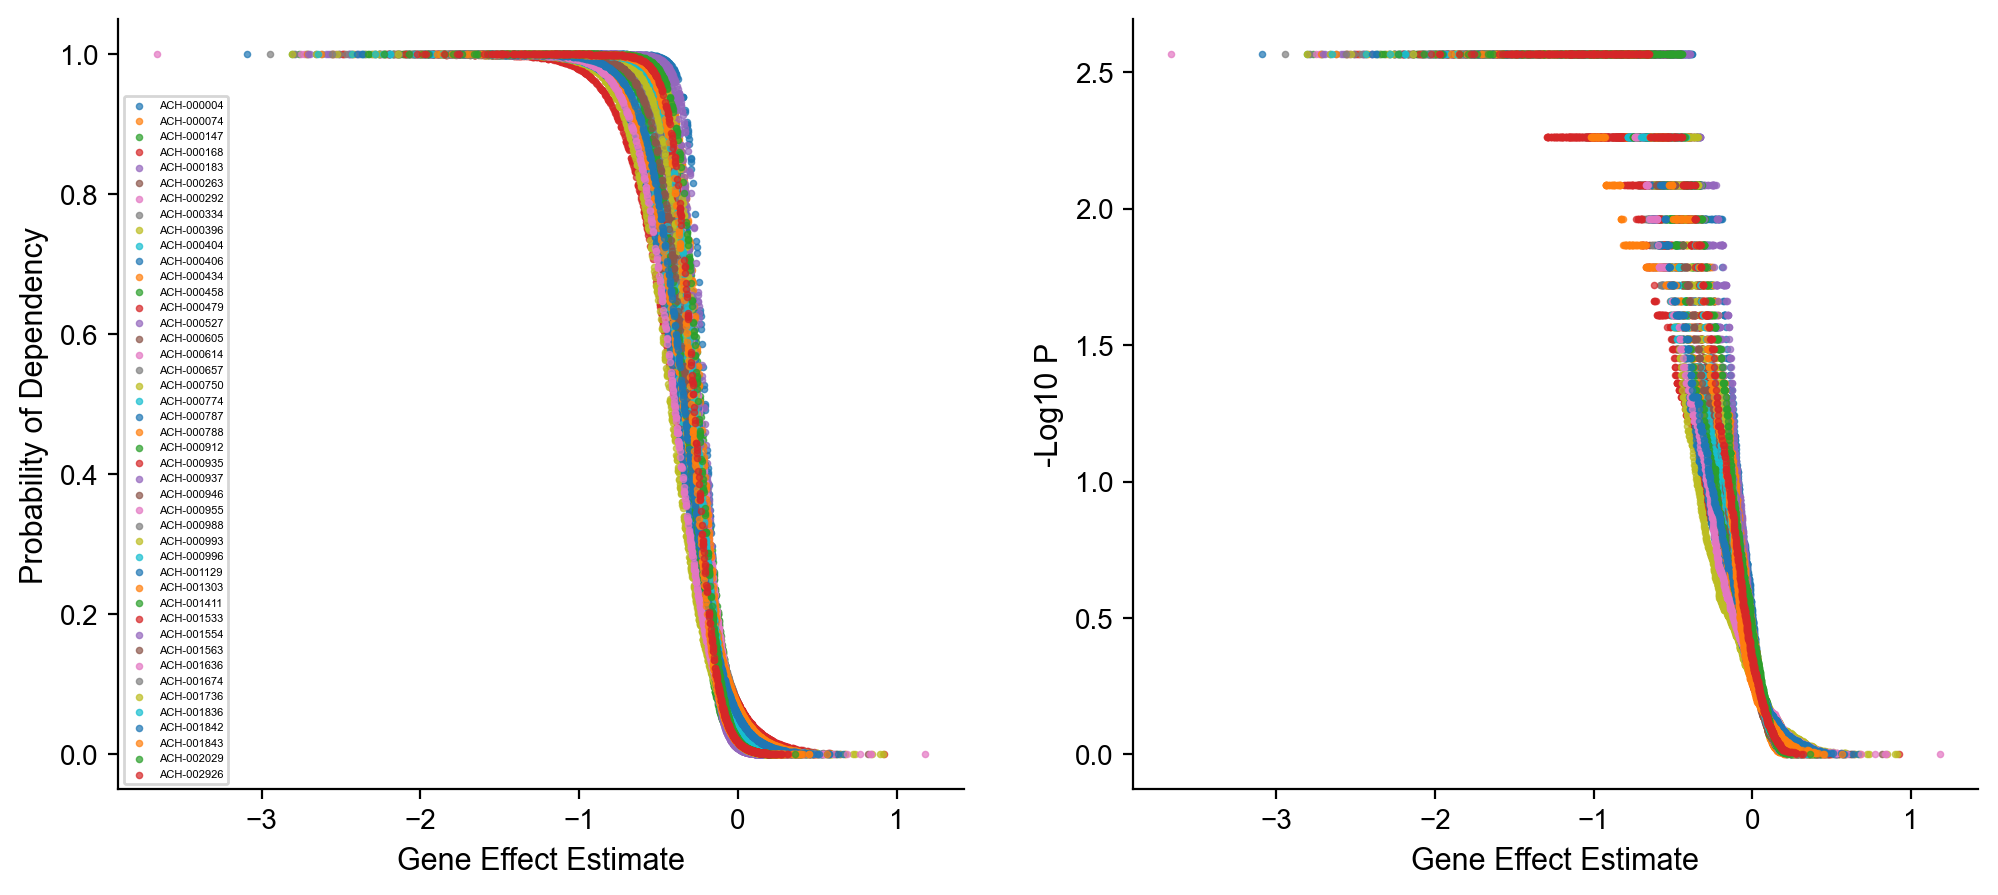

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plt.sca(axes[0])
for ind in probabilities.index:
    plt.scatter(corrected.loc[ind], probabilities.loc[ind], s=5, alpha=.7, linewidth=.5, label=ind)
plt.legend(fontsize=4, loc="lower left")
plt.xlabel("Gene Effect Estimate")
plt.ylabel("Probability of Dependency")

plt.sca(axes[1])
for ind in pvalues.index:
    plt.scatter(corrected.loc[ind], -np.log10(pvalues.loc[ind]), s=5, alpha=.7, linewidth=.5, label=ind)
plt.xlabel("Gene Effect Estimate")
plt.ylabel("-Log10 P")

We can make a roughly head-to-head comparison of discoveries from the two methods by estimating a false discovery rate using each. Using p-values for many hypotheses, false discovery is typically controlled with the Benjamini-Hochberg procedure. This is a frequentist FDR. In contrast, using probabilities of dependency, we can directly estimate the Bayesian FDR: the number of true discoveries below a threshold is just the sum of the probabilities of dependency. See https://arxiv.org/pdf/1803.05284.pdf for a discussion of frequentist and Bayesian false discovery.

In [44]:
from chronos.hit_calling import get_fdr_from_probabilities, get_fdr_from_pvalues
fdr_from_probabilities = get_fdr_from_probabilities(probabilities)
fdr_from_pvalues = get_fdr_from_pvalues(pvalues)

We'll do a quick, nonrigorous calibration check, considering only the control sets:

In [45]:
def calibration_check(fdr, positive_controls, negative_controls):
    controls_only = fdr\
    .reindex(columns=list(positive_controls) + list(negative_controls))\
    .dropna(axis=1)

    is_essential = pd.DataFrame(
        np.repeat(
            controls_only.columns.isin(positive_controls).reshape(1, -1), 
            len(controls_only), axis=0
        ),
       index=controls_only.index,
        columns=controls_only.columns
    )
    
    calibration = pd.DataFrame({
        "FDR": np.ravel(controls_only),
        "IsTrue": np.ravel(is_essential)
    }).sort_values("FDR")
    calibration["ProportionFalse"] = np.cumsum(~calibration.IsTrue) / np.arange(1, len(calibration)+1)
    
    return calibration

In [46]:
calibration_probabilities = calibration_check(fdr_from_probabilities, common_essentials, nonessentials)
calibration_pvalues = calibration_check(fdr_from_pvalues, common_essentials, nonessentials)

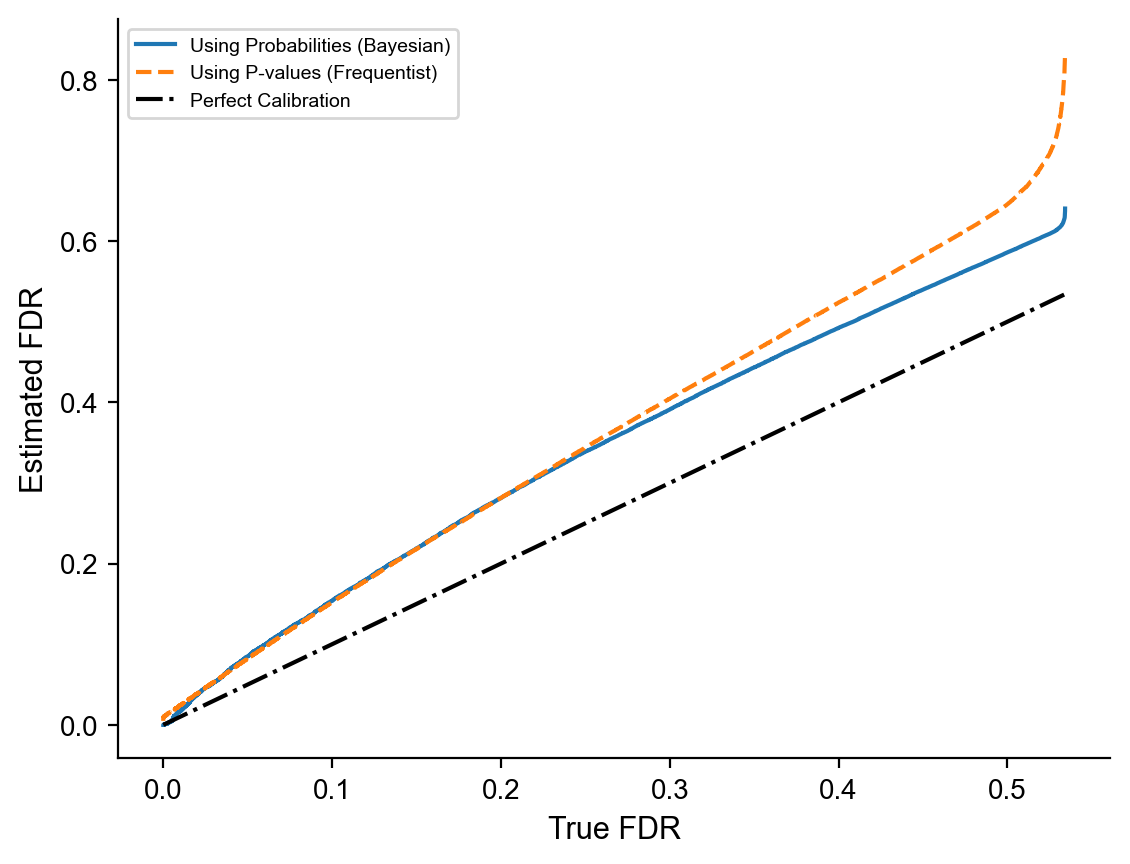

In [47]:
plt.plot(
    calibration_probabilities["ProportionFalse"],
    calibration_probabilities["FDR"],
    label="Using Probabilities (Bayesian)"
)

plt.plot(
    calibration_pvalues["ProportionFalse"],
    calibration_pvalues["FDR"],
    '--', 
    label="Using P-values (Frequentist)"
)

max_fdr = calibration_probabilities.ProportionFalse.max()
plt.plot([0, max_fdr], [0, max_fdr], '-.', color="black", label="Perfect Calibration")

plt.ylabel("Estimated FDR")
plt.xlabel("True FDR")
plt.legend()

We can see that both estimates of FDR are conservative, which is surely preferable to being optimistic. This may be partly due to the presence of the noncontrol genes in the full data, which have a lower proportion of true dependencies than the controls and affect the FDR estimates in the controls. The probability based method has an unfair advantage as it as seen the same set of positive controls as well as the negative controls. To be truly rigorous we would need to split the controls used in training and in evaluating calibration, and run Chronos without any non-control genes. 

We should also note that having a large number of true dependencies our test library improves the apparent performance of the frequentist method, because it allows values to remain significant after the BH procedure. In a setting with few true dependencies, the frequentist method may become severely underpowered.

Summing up: using `get_probability_dependent` is more powerful, and especially so in the case of subgenome libraries with limited negative control sets and a modest proportion of true hits. However, it requires correctly specifying the positive control distribution by identifying _representative_ positive control genes independently from your screening data (ideally, independent of any CRISPR data). 

## Comparing a Screen in Two Conditions

### Data Format for Comparing Conditions

A common use case for comparing screens is the anchor screen, in which the same model is screened in two different conditions. In [DeWeirdt et al.](https://doi.org/10.1038%2Fs41467-020-14620-6) (2020), the Meljuso, OVCAR8, and A375 cell lines were screened using either small molecule inhibitors or S. Aureus knockouts of BCL2L1, MCL1, and PARP/PARP1 in combination with the Brunello genome-wide library. A subset of their screens with the BCL2L1 inhibitor A-1331852 is loaded below.

In [48]:
deweird_readcounts = chronos.read_hdf5("Data/SampleData/DeWeirdtReadcounts.hdf5")

deweirdt_condition_map = pd.read_csv("Data/SampleData/DeWeirdtConditionMap.csv")

deweirdt_guide_map = pd.read_csv("Data/SampleData/DeWeirdtGuideMap.csv")

deweirdt_negative_controls = deweirdt_guide_map.sgrna[
    deweirdt_guide_map.gene.isin([s.split(' ')[0] for s in nonessentials])
]

The readcounts and guide maps are formatted just like the Avana data above. The condition map is very similar to a sequence map, but requires two additional columns: `"replicate"` and `"condition"`. __Different replicates should be biologically independent__, ideally independently library-transfected cell populations. Different sequences of the same replicate should be assigned the same replicate name.

In [49]:
deweirdt_condition_map

,sequence_ID,replicate,cell_line_name,days,pDNA_batch,condition
0,pDNA,pDNA,pDNA,21,batch1,pDNA
1,Meljuso,RepA,Meljuso,21,batch1,Control
2,Meljuso.1,RepB,Meljuso,21,batch1,Control
3,Meljuso.2,RepA,Meljuso,21,batch1,A-1331852
4,Meljuso.3,RepB,Meljuso,21,batch1,A-1331852
5,OVCAR8,RepA,OVCAR8,21,batch1,Control
6,OVCAR8.1,RepB,OVCAR8,21,batch1,Control
7,OVCAR8.2,RepA,OVCAR8,21,batch1,A-1331852
8,OVCAR8.3,RepB,OVCAR8,21,batch1,A-1331852


Any cell line with less than two unique replicates in each of the two conditions being compared will not be evaluated.

It is important when running the comparison to first normalize the readcounts and `nan_outgrowths`. Otherwise, outliers that occur in single replicates will produce excessive noise that will reduce statistical power.

In [50]:
deweirdt_normed = chronos.normalize_readcounts(deweird_readcounts, deweirdt_negative_controls, deweirdt_condition_map)

In [51]:
chronos.nan_outgrowths(deweirdt_normed, deweirdt_condition_map, deweirdt_guide_map, rpm_normalize=False)

calculating LFC
stacking and annotating LFC
finding group boundaries
removing cases with only one guide and replicate
finding maximal values
making mask
found 13 outgrowths, 2.3E-05 of the total
pivoting mask
aligning_mask
NaNing


### Training with Conditions Distinguished

To understand how `ChronosComparison` works, it helps to first manually create a model with conditions distinguished. First, we create a sequence map that distinguishes conditions. We'll compare "Control" and "A-1331852". The function `create_condition_map` creates the map, while the function `filter_sequence_map_by_condition` restricts the sequences considered to those matching one of the designated conditions and to cell lines with at least two unique replicates in each batch. It also will trim the number of replicates considered so that there is an even and equal number in each condition for each the cell line.

In [52]:
from chronos.hit_calling import filter_sequence_map_by_condition, create_condition_sequence_map

condition_pair = ("Control", "A-1331852")
distinguished_map = create_condition_sequence_map(
    filter_sequence_map_by_condition(deweirdt_condition_map, condition_pair),
    condition_pair
)
    

In [53]:
distinguished_map

,sequence_ID,replicate,cell_line_name,days,pDNA_batch,condition,true_cell_line_name
0,pDNA,pDNA,pDNA,21,batch1,pDNA,pDNA
1,Meljuso,RepA,Meljuso__in__Control,21,batch1,Control,Meljuso
2,Meljuso.1,RepB,Meljuso__in__Control,21,batch1,Control,Meljuso
3,Meljuso.2,RepA,Meljuso__in__A-1331852,21,batch1,A-1331852,Meljuso
4,Meljuso.3,RepB,Meljuso__in__A-1331852,21,batch1,A-1331852,Meljuso
5,OVCAR8,RepA,OVCAR8__in__Control,21,batch1,Control,OVCAR8
6,OVCAR8.1,RepB,OVCAR8__in__Control,21,batch1,Control,OVCAR8
7,OVCAR8.2,RepA,OVCAR8__in__A-1331852,21,batch1,A-1331852,OVCAR8
8,OVCAR8.3,RepB,OVCAR8__in__A-1331852,21,batch1,A-1331852,OVCAR8


Notice that the `"cell_line_name"` column has been overwritten in the format "<cell_line>__in__<condition>". When we train Chronos, we'll get an individual assessment of each gene's effect in each cell line in each condition. The new column `"true_cell_line_name"` exists for convenience.

Running Chronos works just like before:

In [54]:
distinguished_model = chronos.Chronos(
    readcounts={"brunello": deweird_readcounts},
    sequence_map={"brunello": distinguished_map},
    guide_gene_map={"brunello": deweirdt_guide_map},
    negative_control_sgrnas={"brunello": deweirdt_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 71848 unique guides and 18238 unique genes in brunello
found 71848 unique guides and 18238 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 8 unique sequences (excluding pDNA), 8 unique replicates, and 4 unique cell lines in brunello
found 8 unique late time points and 4 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for brunello
Creating excess variance tensors
	Created excess variance tensor for brunello with shape [8, 1]
initializing graph

building gene effect mask

building doubling vectors
made days vector of shape [8, 1] for brunello

building late observed timepoints
	built normalized timepoints for brunello with shape (8, 71848

2025-05-12 14:44:23.130875: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_2/brunello/Assign' id:6159 op device:{requested: '', assigned: ''} def:{{{node excess_variance_2/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_2/brunello, excess_variance_2/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


building other regularizations

Creating optimizer
initializing rest of graph


2025-05-12 14:44:23.861872: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_2/library_effect/brunello/Assign' id:6273 op device:{requested: '', assigned: ''} def:{{{node GE_2/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_2/library_effect/brunello, GE_2/library_effect/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 brunello
	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	brunello _gene_effect
	brunello _selected_efficacies
	brunello_predicted_readcounts_unscaled
	brunello _predicted_readcounts
	brunello _normalized_readcounts
	brunello _cost_presum
	brunello _cost
	brunello _full_costs
ready to train


In [55]:
distinguished_model.train()

NB2 cost 0.3609438979120542
Full cost 0.37500230249287364
relative_growth_rate
	brunello max 1.017, min 0.97255
mean guide efficacy 0.9992172029848414
t0_offset SD: [('brunello', 6.764094073252833e-05)]

gene mean -0.0665422125022644
SD of gene means 0.2153642628425073
Mean of gene SDs 0.08467166736734871



51 epochs trained, time taken 0:00:22, projected remaining 0:01:48
NB2 cost 0.19805190380472035
Full cost 0.2313025036018826
relative_growth_rate
	brunello max 1.227, min 0.80206
mean guide efficacy 0.9240070621117722
t0_offset SD: [('brunello', 0.14925897010478598)]

gene mean 0.06597014219737504
SD of gene means 0.3575409855893324
Mean of gene SDs 0.11382279655867826



101 epochs trained, time taken 0:00:44, projected remaining 0:01:26
NB2 cost 0.17918909167262273
Full cost 0.20420992057475904
relative_growth_rate
	brunello max 1.132, min 0.87149
mean guide efficacy 0.8278598435352426
t0_offset SD: [('brunello', 0.14422847779254216)]

gene mean -0.00023062309879566789
SD of gene

MCL1 and BCL2L1 are a well-established synthetic lethal pair in cancer. Below, we see a difference of about 1.5 between the gene effects of MCL1 in the control condition and in the BCL2L1 inhibitor A-1331852. 

In [56]:
distinguished_model.gene_effect['MCL1']

cell_line_name
Meljuso__in__A-1331852   -1.660278
Meljuso__in__Control      0.074527
OVCAR8__in__A-1331852    -1.363069
OVCAR8__in__Control       0.066117
Name: MCL1, dtype: float64

But are these differences significant?

### Running the Comparator

To test for significance, we first create a `hit_calling.ConditionComparison` instance. The input syntax is almost exactly the same as a `Chronos` model instance, except we replace the `sequence_map` argument with a `condition_map`.

In [57]:
from chronos.hit_calling import ConditionComparison
comparator = ConditionComparison(
    readcounts={"brunello": deweird_readcounts},
    condition_map={"brunello": deweirdt_condition_map},
    guide_gene_map={"brunello": deweirdt_guide_map},
    negative_control_sgrnas={"brunello": deweirdt_negative_controls},
)

checking for high negative control correlation between replicates in the same condition


To identify significant differences, `ConditionComparison` will first train a distinguished model, as above, then permute the condition labels so that each condition label has an equal number of replicates from each of the real conditions and train models on the permutations. These models have no biological difference between conditions, and can be used to form the null distribution. Permutations that have every condition flipped from an existing permutation are discarded. An example of a permuted map is shown below.

In [58]:
from chronos.hit_calling import create_permuted_sequence_maps

create_permuted_sequence_maps(deweirdt_condition_map, condition_pair)[0]

,cell_line_name,condition,replicate_ID,pDNA_batch,true_condition,sequence_ID,replicate,days,true_cell_line_name
0,Meljuso__in__A-1331852,A-1331852,Meljuso__IN__A-1331852_RepA_batch1,batch1,A-1331852,Meljuso.2,RepA,21,Meljuso
1,Meljuso__in__Control,Control,Meljuso__IN__A-1331852_RepB_batch1,batch1,A-1331852,Meljuso.3,RepB,21,Meljuso
2,Meljuso__in__A-1331852,A-1331852,Meljuso__IN__Control_RepA_batch1,batch1,Control,Meljuso,RepA,21,Meljuso
3,Meljuso__in__Control,Control,Meljuso__IN__Control_RepB_batch1,batch1,Control,Meljuso.1,RepB,21,Meljuso
4,OVCAR8__in__A-1331852,A-1331852,OVCAR8__IN__A-1331852_RepA_batch1,batch1,A-1331852,OVCAR8.2,RepA,21,OVCAR8
5,OVCAR8__in__Control,Control,OVCAR8__IN__A-1331852_RepB_batch1,batch1,A-1331852,OVCAR8.3,RepB,21,OVCAR8
6,OVCAR8__in__A-1331852,A-1331852,OVCAR8__IN__Control_RepA_batch1,batch1,Control,OVCAR8,RepA,21,OVCAR8
7,OVCAR8__in__Control,Control,OVCAR8__IN__Control_RepB_batch1,batch1,Control,OVCAR8.1,RepB,21,OVCAR8
8,pDNA,pDNA,pDNA__IN__pDNA_pDNA_batch1,batch1,pDNA,pDNA,pDNA,21,pDNA


The number of permutations limits the minimum p-value that can be calculated. Due to the requirement that we only consider permutations that have equal numbers of replicates from each condition, the number of permutations actually generated is as follows:

- Less than 2 replicates for any condition for a cell line: 0 permutations, that line is discarded
- 2-3 replicates for any condition of any cell line: 2 permutations
- At least 4 replicates for all conditions for all cell lines: 18 permutations
- At least 6 replicates for all conditions for all cell lines: 200 permutations
  
For obvious reasons, we don't recommend including more than 4 replicates per condition unless your library is very small.

Now, to compare the conditions. Note that with three models to train, this may take about 10 minutes.

In [59]:
comparison_statistics = comparator.compare_conditions(("Control", "A-1331852"))

training model without conditions distinguished


2025-05-12 14:46:35.355842: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_3/brunello/Assign' id:9167 op device:{requested: '', assigned: ''} def:{{{node excess_variance_3/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_3/brunello, excess_variance_3/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-05-12 14:46:36.118316: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_3/library_effect/brunello/Assign' id:9281 op device:{requested: '', assigned: ''} def:{{{node GE_3/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_3/library_effect/brunello, GE_3/library_effect/brunello/Initializer/initial_value)}}' was ch

training model with conditions distinguished


2025-05-12 14:48:38.524231: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_4/brunello/Assign' id:12169 op device:{requested: '', assigned: ''} def:{{{node excess_variance_4/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_4/brunello, excess_variance_4/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-05-12 14:48:39.523660: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_4/library_effect/brunello/Assign' id:12283 op device:{requested: '', assigned: ''} def:{{{node GE_4/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_4/library_effect/brunello, GE_4/library_effect/brunello/Initializer/initial_value)}}' was 

training models with permuted conditions
	random iteration 0


2025-05-12 14:48:59.527196: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_5/brunello/Assign' id:15178 op device:{requested: '', assigned: ''} def:{{{node excess_variance_5/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_5/brunello, excess_variance_5/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-05-12 14:49:00.539955: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_5/library_effect/brunello/Assign' id:15292 op device:{requested: '', assigned: ''} def:{{{node GE_5/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_5/library_effect/brunello, GE_5/library_effect/brunello/Initializer/initial_value)}}' was 

	random iteration 1


2025-05-12 14:49:21.571005: W tensorflow/c/c_api.cc:305] Operation '{name:'excess_variance_6/brunello/Assign' id:18187 op device:{requested: '', assigned: ''} def:{{{node excess_variance_6/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](excess_variance_6/brunello, excess_variance_6/brunello/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-05-12 14:49:22.666388: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_6/library_effect/brunello/Assign' id:18301 op device:{requested: '', assigned: ''} def:{{{node GE_6/library_effect/brunello/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_6/library_effect/brunello, GE_6/library_effect/brunello/Initializer/initial_value)}}' was 

calculating empirical significance


Below, we can see the most significant differences. The expected hit MCL1 was found in both screens, while BAX and BCL2 were found in Meljuso. [MARCH5, UBE2J, and UBE2K are also expected findings](https://doi.org/10.1038/s41375-024-02178-x). Meljuso appears to be a cleaner screen with overall more significant hits.

In [60]:
comparison_statistics.sort_values(["gene"]).loc[lambda x: x.likelihood_fdr < .05]

,cell_line_name,gene,gene_effect_in_Control,gene_effect_in_A-1331852,gene_effect_difference,gene_effect_difference_permutation_0,gene_effect_difference_permutation_1,likelihood,likelihood_undistinguished,likelihood_permutation_0,likelihood_permutation_1,likelihood_pval,readcount_bin,likelihood_fdr
1384,Meljuso,BAX,0.171959,0.964396,0.792436,0.060120,-0.023331,-1233.241349,-1264.390335,-1263.410918,-1263.547629,7.970986e-07,"(815.0, 12384.75]",0.003165
8909,Meljuso,MARCH5,0.335079,-1.208868,-1.543948,-0.053241,-0.235503,-957.906367,-1025.905096,-1025.428455,-1023.511868,2.760106e-09,"(815.0, 12384.75]",0.000050
8993,Meljuso,MCL1,0.175367,-1.304899,-1.480267,0.021013,-0.205156,-899.735351,-943.379460,-943.001153,-941.955873,7.825060e-08,"(815.0, 12384.75]",0.000713
11870,Meljuso,PMAIP1,0.122811,0.942735,0.819924,0.076394,-0.054397,-1061.277853,-1092.027454,-1090.474155,-1090.615530,8.678068e-07,"(815.0, 12384.75]",0.003165
16802,Meljuso,UBE2J2,0.297961,-0.961277,-1.259238,-0.221176,-0.293289,-915.369191,-949.799539,-948.286697,-947.340825,4.082166e-07,"(815.0, 12384.75]",0.002481


With multiple cell lines in the same pair of conditions, you may be interested in what change in what genes can be recovered by considering all lines together. `get_consensus_difference_statistics` combines likelihood changes across cell lines to create a consensus estimate of significance. This reports a number of additional genes not significant in either cell line individually.

In [61]:
from chronos.hit_calling import get_consensus_difference_statistics
consensus = get_consensus_difference_statistics(comparison_statistics)
consensus.sort_values("likelihood_fdr").loc[lambda x: x.likelihood_fdr < .05]

,mean_gene_effect_difference,mean_gene_effect_difference_permutation_0,mean_gene_effect_difference_permutation_1,likelihood_p,likelihood_fdr
gene,,,,,
MARCH5,-1.169091,0.108786,-0.098507,8.930395e-13,1.628100e-08
MCL1,-1.293835,0.371813,-0.086127,1.066349e-11,9.720303e-08
UBE2J2,-1.138113,0.002796,-0.173870,3.581485e-10,2.176468e-06
BAX,0.677318,0.067146,0.071862,1.223913e-09,5.578289e-06
PMAIP1,0.623434,0.035673,0.071487,8.171250e-09,2.979401e-05
UBE2K,-0.937287,0.241527,0.072497,2.434181e-08,7.396260e-05
THOC6,-0.723707,0.074225,0.056101,5.141864e-06,1.339162e-02


### Other notes

If you want to compare two different screens in the same condition, you can create a condition map in which the two cell lines are assigned the same `"cell_line_name"` but a different `"condition"`. However, bear in mind that your real differences are likely to be confounded with batch effects. You can assess the degree of this problem by checking for false discoveries among negative controls or unexpressed genes.

You may also find that your hits are dominated by common essentials. This can happen because the two conditions have different screen quality. In particular, if one condition is mildly or moderately growth-inhibiting, this can lead to less apparent common essential dropout (because all other cells are also dropping out) vs the other condition and make these genes appear systematically different in gene effect. This can be addressed by both increasing the `gene_effect_hierarchical` regularization in `ChronosCompare` (see `chronos.Chronos` for a description), and potentially also adding new bins to `gene_readcount_total_bin_quantiles` (default": `[0.05]`) in `compare_conditions` (see `chronos.hit_calling.ConditionComparison.compare_conditions`.)

## Running with multiple libraries

We can add Sanger's [Project Score](https://www.nature.com/articles/s41586-019-1103-9) data (screened with the KY library) and run Chronos jointly on it and the Avana data. 

In [62]:
ky_guide_map = pd.read_csv("./Data/SampleData/KYGuideMap.csv")
ky_sequence_map = pd.read_csv("./Data/SampleData/KYSequenceMap.csv")
ky_readcounts = chronos.read_hdf5("./Data/SampleData/KYReadcounts.hdf5")

In [63]:
ky_positive_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(common_essentials)]
ky_negative_controls = ky_guide_map.sgrna[ky_guide_map.gene.isin(nonessentials)]

Note how the call signature of Chronos with multiple libraries is constructed:

In [64]:
ky_readcounts.isnull().sum(axis=1).sort_values()

pDNA_batch_KY-2        0
pDNA_batch_KY-1        0
RCCFG2_C908R3_KY-1     1
RCCFG2_C908R2_KY-1     1
RCCFG2_C908R1_KY-1     1
                      ..
HEC1_c907R3_KY-1      24
HEC1_c907R2_KY-1      24
SNU81_c903R1_KY-2     37
SNU81_c903R2_KY-2     37
SNU81_c903R3_KY-2     37
Length: 65, dtype: int64

In [65]:
model2 = chronos.Chronos(
    sequence_map={"avana": sequence_map, 'ky': ky_sequence_map},
    guide_gene_map={"avana": guide_map, 'ky': ky_guide_map},
    readcounts={"avana": readcounts, 'ky': ky_readcounts},
    negative_control_sgrnas={"avana": negative_controls, "ky": ky_negative_controls}
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in avana
found 4084 unique guides and 833 unique genes in ky
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in avana
found 63 unique sequences (excluding pDNA), 63 unique replicates, and 23 unique cell lines in ky
found 155 unique late time points and 58 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for avana
	Estimating excess variance (alpha) for ky
Creating excess variance tensors
	Created excess variance tensor for avana with shape [92, 1]
	Created excess variance tensor for

2025-05-12 14:49:45.578937: W tensorflow/c/c_api.cc:305] Operation '{name:'inferred_t0_7/base_avana/Assign' id:21224 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_7/base_avana/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_7/base_avana, inferred_t0_7/base_avana/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph


2025-05-12 14:49:47.220478: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_7/library_effect/ky/Assign' id:21381 op device:{requested: '', assigned: ''} def:{{{node GE_7/library_effect/ky/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_7/library_effect/ky, GE_7/library_effect/ky/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 avana
	 ky
	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	avana _gene_effect
	avana _selected_efficacies
	avana_predicted_readcounts_unscaled
	avana _predicted_readcounts
	avana _normalized_readcounts
	avana _cost_presum
	avana _cost
	avana _full_costs
	ky _gene_effect
	ky _selected_efficacies
	ky_predicted_readcounts_unscaled
	ky _predicted_readcounts
	ky _normalized_readcounts
	ky _cost_presum
	ky _cost
	ky _full_costs
ready to train


In [66]:
model2.train(301)

NB2 cost 0.36022240608721856
Full cost 0.5053889969239664
relative_growth_rate
	avana max 1.057, min 0.95951
	ky max 1.045, min 0.94626
mean guide efficacy 0.9992103912224544
t0_offset SD: [('avana', 7.03955019008314e-05), ('ky', 7.562278368155407e-05)]

gene mean -0.26206581119342853
SD of gene means 0.425787935359659
Mean of gene SDs 0.3411359454927494



51 epochs trained, time taken 0:00:03, projected remaining 0:00:17
NB2 cost 0.25287472108837106
Full cost 0.31240356027161903
relative_growth_rate
	avana max 1.309, min 0.54478
	ky max 1.466, min 0.41612
mean guide efficacy 0.9376767849681397
t0_offset SD: [('avana', 0.1401649779279664), ('ky', 0.1385712793186922)]

gene mean -0.023712226845341612
SD of gene means 0.5438113962756431
Mean of gene SDs 0.27379390134290016



101 epochs trained, time taken 0:00:06, projected remaining 0:00:12
NB2 cost 0.23461761014751792
Full cost 0.25834990951323145
relative_growth_rate
	avana max 1.561, min 0.48624
	ky max 1.318, min 0.63813
mean guid

Note that the gene effect now has NAs. These are cases where a cell line was only screened in one library and that library had no guides for that gene.

Chronos infers library batch effects. Note that these are only inferred for genes present in all libraries

## Running your screen with pretrained DepMap parameters

If you conducted a screen in one of the DepMap integrated libraries (currently Avana, KY, or Humagne-CD), you can load parameters from the trained DepMap model and use them to process your specific screen. This gives you many of the benefits of coprocessing your screen with the complete DepMap dataset without the computational expense. 

The following command fetches the 22Q3 public dataset from Figshare and stores it in the Chronos package directory under Data/DepMapParameters

In [67]:
chronos.fetch_parameters()

`url_loc` will be found relative to the chronos package directory
'/Users/dempster/packages/chronos_public/chronos'
Pass `relative_to_chronos=False` to make the path relative to your current working directory
'/Users/dempster/packages/chronos_public'
instead.

`output_dir` will be found relative to the chronos package directory
'/Users/dempster/packages/chronos_public/chronos'
Pass `relative_to_chronos=False` to make the path relative to your current working directory
'/Users/dempster/packages/chronos_public'
instead.

downloading files to /Users/dempster/packages/chronos_public/chronos/../Data/DepMapParameters/
Skipping gene_effect.csv as it already exists, pass `overwrite=True` to overwrite
Skipping guide_efficacy.csv as it already exists, pass `overwrite=True` to overwrite
Skipping cell_line_efficacy.csv as it already exists, pass `overwrite=True` to overwrite
Skipping library_effect.csv as it already exists, pass `overwrite=True` to overwrite
Skipping t0_offset.csv as it already ex

/Users/dempster/packages/chronos_public/chronos/fetch_parameters.py:39: ResourceWarning: unclosed file <_io.TextIOWrapper name='/Users/dempster/packages/chronos_public/chronos/../Data/DepMapDataURLs.json' mode='r' encoding='UTF-8'>
  url_dict = json.loads(open(url_loc).read())


done


First, we create a model with the data we want to train as before, but with two important details:
- we pass the argument `pretrained=True` when we initialize
- the library batch names must match the DepMap library batch names, as that's what we're using for the pretrained model

In [68]:
model2_pretrained = chronos.Chronos(
    sequence_map={"Achilles-Avana-2D": sequence_map, 'Achilles-KY-2D': ky_sequence_map},
    guide_gene_map={"Achilles-Avana-2D": guide_map, 'Achilles-KY-2D': ky_guide_map},
    readcounts={"Achilles-Avana-2D": readcounts, 'Achilles-KY-2D': ky_readcounts},
    negative_control_sgrnas={"Achilles-Avana-2D": negative_controls, "Achilles-KY-2D": ky_negative_controls},
    pretrained=True
)

normalizing readcounts


Finding all unique guides and genes
found 3474 unique guides and 883 unique genes in Achilles-Avana-2D
found 4084 unique guides and 833 unique genes in Achilles-KY-2D
found 7558 unique guides and 887 unique genes overall

finding guide-gene mapping indices

finding all unique sequenced replicates, cell lines, and pDNA batches
found 92 unique sequences (excluding pDNA), 92 unique replicates, and 44 unique cell lines in Achilles-Avana-2D
found 63 unique sequences (excluding pDNA), 63 unique replicates, and 23 unique cell lines in Achilles-KY-2D
found 155 unique late time points and 58 unique cell lines overall

finding sequence-cell line mappings indices

finding replicate mappings indices

finding late time point-pDNA mappings indices


assigning float constants
Estimating or aligning variances
	Estimating excess variance (alpha) for Achilles-Avana-2D
	Estimating excess variance (alpha) for Achilles-KY-2D
Creating excess variance tensors
	Created excess variance

2025-05-12 14:50:11.084686: W tensorflow/c/c_api.cc:305] Operation '{name:'inferred_t0_8/base_Achilles-Avana-2D/Assign' id:26104 op device:{requested: '', assigned: ''} def:{{{node inferred_t0_8/base_Achilles-Avana-2D/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](inferred_t0_8/base_Achilles-Avana-2D, inferred_t0_8/base_Achilles-Avana-2D/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.




Building all costs

assembling guide efficacy regularization
building smoothed regularization

building t0 reads regularization/cost

building NB2 cost
building other regularizations

Creating optimizer
initializing rest of graph


2025-05-12 14:50:12.876718: W tensorflow/c/c_api.cc:305] Operation '{name:'GE_8/library_effect/Achilles-KY-2D/Assign' id:26254 op device:{requested: '', assigned: ''} def:{{{node GE_8/library_effect/Achilles-KY-2D/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_DOUBLE, validate_shape=false](GE_8/library_effect/Achilles-KY-2D, GE_8/library_effect/Achilles-KY-2D/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


estimating initial screen efficacy and gene effect
	 Achilles-Avana-2D
	 Achilles-KY-2D
	verifying graph integrity
verifying user inputs
verifying variables
verifying calculated terms
	Achilles-Avana-2D _gene_effect
	Achilles-Avana-2D _selected_efficacies
	Achilles-Avana-2D_predicted_readcounts_unscaled
	Achilles-Avana-2D _predicted_readcounts
	Achilles-Avana-2D _normalized_readcounts
	Achilles-Avana-2D _cost_presum
	Achilles-Avana-2D _cost
	Achilles-Avana-2D _full_costs
	Achilles-KY-2D _gene_effect
	Achilles-KY-2D _selected_efficacies
	Achilles-KY-2D_predicted_readcounts_unscaled
	Achilles-KY-2D _predicted_readcounts
	Achilles-KY-2D _normalized_readcounts
	Achilles-KY-2D _cost_presum
	Achilles-KY-2D _cost
	Achilles-KY-2D _full_costs
waiting for user to load model


Now we import the DepMap data from the directory into the model, and train:

In [69]:
model2_pretrained.import_model("./Data/DepMapParameters/")

Chronos model loaded
ready to train


In [70]:
model2_pretrained.train()

NB2 cost 0.26865641628548176
Full cost 0.45839815130848227
relative_growth_rate
	Achilles-Avana-2D max 1.041, min 0.95611
	Achilles-KY-2D max 1.052, min 0.95889
mean guide efficacy 0.8814048828522121
t0_offset SD: [('Achilles-Avana-2D', 0.1755915504675398), ('Achilles-KY-2D', 0.14386042441508556)]

gene mean -0.4494746781647708
SD of gene means 0.6593218591023047
Mean of gene SDs 0.3385869759452148



51 epochs trained, time taken 0:00:02, projected remaining 0:00:09
NB2 cost 0.23922275225931414
Full cost 0.34679107057420644
relative_growth_rate
	Achilles-Avana-2D max 1.499, min 0.52215
	Achilles-KY-2D max 1.352, min 0.60446
mean guide efficacy 0.8814048828522121
t0_offset SD: [('Achilles-Avana-2D', 0.1755915504675398), ('Achilles-KY-2D', 0.14386042441508556)]

gene mean -0.39951331341885543
SD of gene means 0.6922726215425694
Mean of gene SDs 0.28541891878690306



101 epochs trained, time taken 0:00:03, projected remaining 0:00:05
NB2 cost 0.22951313875798865
Full cost 0.309384760466